# Tutorial on ECOSIS API
This jupyter notebook shows how to access [ECOSIS](https://ecosis.org/) API and retrieve data/create visualizations. The API documentation is provided here:http://cstars.github.io/ecosis/.

First, import python modules.

In [1]:
import requests
import urllib
import pandas as pd
import matplotlib.pyplot as plt

## Search ECOSIS
We will search for ECOSIS database for the spectra data of two plants by their latin names: *Salix nigra* (Black willow) and *Betula papyrifera* (Paper Birch)

In [2]:
# base URL of ECOSIS API
baseurl = "https://ecosis.org/api"

# search API url
searchurl = f"{baseurl}/package/search"

# defining search parameters
searchjson = {"filters": '[{"Latin Genus":"salix"},{"Latin Genus":"betula"},{"Latin Species":"nigra"},{"Latin Species":"papyrifera"}]',
             "start":0,
             "stop":100}

# needed to maintain spaces in search parameters
params = urllib.parse.urlencode(searchjson, quote_via=urllib.parse.quote)

# submit request
response = requests.get(searchurl, params=params)
response.raise_for_status()

# print total spectra
print(f"A total of {response.json()['total']} datasets found")

A total of 10 datasets found


Now, let's remove the dataset that have "DO NOT USE" labels in descriptions and get their ids (`_id`).

In [3]:
dataset_id = []
for item in response.json()['items']:
    if ("DO NOT USE" not in item['ecosis']['description']):
        dataset_id.append(item['_id'])

# print      
print(f"A total of {len(dataset_id)} datasets do not have DO NOT USE labels. Their dataset ids are: {dataset_id}")

A total of 9 datasets do not have DO NOT USE labels. Their dataset ids are: ['e384a3ed-9778-49b9-8f84-5c86170b3ea4', 'a12286ac-929f-4e3e-9b9c-517e10fe4087', 'ddca5025-2d9a-4769-b7b8-40153d64559d', '9c835870-a6ac-46b4-b7c0-c9d91b5974b5', 'f72dd538-8350-4d45-ab93-617f3c1da6f0', '5617da17-c925-49fb-b395-45a51291bd2d', '4a63d7ed-4c1e-40a7-8c88-ea0deea10072', 'fea0294d-2d39-4576-aab5-7200fdc87068', '3ac9c116-7507-4916-aa10-b49d0c21c5eb']


## Get dataset/spectra
Now, let's loop through each `dataset_id` from above and retrieve dataset and spectra.

In [4]:
# data API url
dataurl = f"{baseurl}/package"

# submit request
response = requests.get(f"{dataurl}/{dataset_id[0]}")
response.raise_for_status()

# total number of spectra
spectra_n = int(response.json()['ecosis']['spectra_count'])

# print
print(f"There are {spectra_n} spectra for dataset id {dataset_id[0]}")

There are 664 spectra for dataset id e384a3ed-9778-49b9-8f84-5c86170b3ea4


## Get Spectra

In [5]:
# spectra API url
spectraurl = f"{baseurl}/spectra/search"

# initialize pandas dataframe
spectra_df = pd.DataFrame() 

# the api only allows 100 items at a time
# this loop is for pagination
for start in range(0, spectra_n+1, 100):
    spectrajson = {"start":start, "stop":start + 99}

    # needed to maintain spaces in search parameters
    params = urllib.parse.urlencode(spectrajson, quote_via=urllib.parse.quote)

    # submit request
    response = requests.get(f"{spectraurl}/{dataset_id[0]}", params=params)
    response.raise_for_status()
    
    for item in response.json()['items']:
        # keep only species that are of interest
        if item['FullSpecies'] in ["Salix nigra", "Betula papyrifera"]:
            # getting spectra
            dummy_df = pd.json_normalize(item['datapoints']).apply(pd.to_numeric)
            # species name
            dummy_df['FullSpecies'] = item['FullSpecies']
            # concatenate to pandas dataframe
            spectra_df = pd.concat([spectra_df, dummy_df], ignore_index=True)

# print first few rows
spectra_df = spectra_df.set_index('FullSpecies')
spectra_df[:2]   

,400,401,402,403,404,405,406,407,408,409,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400
FullSpecies,,,,,,,,,,,,,,,,,,,,,
Betula papyrifera,0.114593,0.116645,0.114543,0.109993,0.103421,0.094132,0.085405,0.078824,0.074017,0.071295,...,0.373379,0.373272,0.373074,0.372713,0.372258,0.37176,0.371235,0.370832,0.370533,0.370356
Betula papyrifera,0.114576,0.116475,0.114761,0.110390,0.103725,0.094777,0.086170,0.079279,0.074408,0.071272,...,0.362905,0.362928,0.362785,0.362355,0.361798,0.36129,0.360813,0.360531,0.360414,0.360234


## Plot "Betula papyrifera"

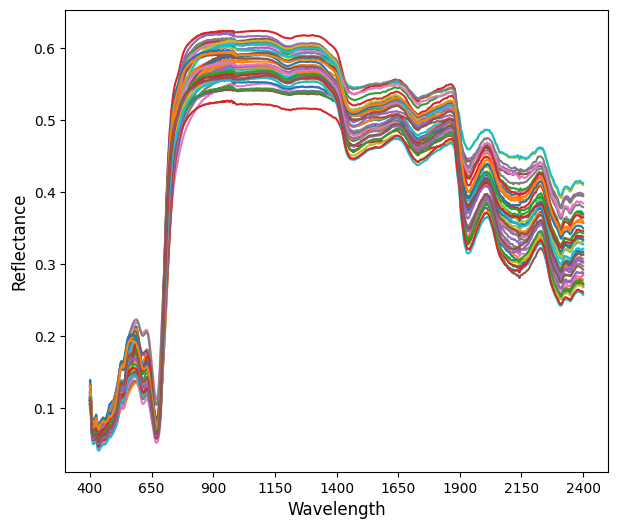

In [6]:
# transpose and plot
ax = spectra_df.loc['Betula papyrifera'].T.plot(figsize=(7, 6), legend=None)
ax.set_ylabel('Reflectance', fontsize=12)
ax.set_xlabel('Wavelength', fontsize=12)
plt.show()

## Plot "Salix nigra"

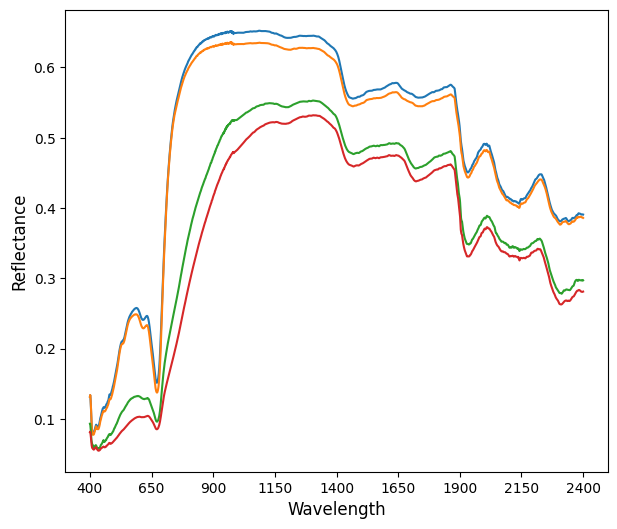

In [7]:
# transpose and plot
ax = spectra_df.loc['Salix nigra'].T.plot(figsize=(7, 6), legend=None)
ax.set_ylabel('Reflectance', fontsize=12)
ax.set_xlabel('Wavelength', fontsize=12)
plt.show()